# Benchmarking Foundation Models Notebook 

Authors:
- Helio Halperin (heliohalperin@gmail.com)
- Simon Lee (simonlee711@g.ucla.edu)

2024

In [3]:
# !pip install "sagemaker>=2.140.0" "transformers==4.26.1" "datasets[s3]==2.10.1" --upgrade
# !pip install git+https://github.com/huggingface/transformers.git

# !pip install transformers datasets[s3] sagemaker --upgrade
# !pip install scikit-learn
# !pip install accelerate==0.21.0
# !pip install fastprogress
# !pip install lightgbm

In [3]:
!pwd

/root/antibiotics-fm-benchmark


In [11]:
# Basic imports
import numpy as np
import pandas as pd
import json
import pickle
import torch
import torch.nn as nn

# AWS imports
# import boto3
# from sagemaker import get_execution_role

# I/O imports
from io import StringIO

# Progress and visualization imports
from tqdm.auto import tqdm
from fastprogress.fastprogress import master_bar, progress_bar
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

# Sklearn metrics imports
from sklearn.metrics import roc_curve, precision_recall_curve
from sklearn.metrics import roc_auc_score, average_precision_score, f1_score

# Transformers imports
from transformers import (AutoModel, AutoModelForSequenceClassification, AutoTokenizer, AutoConfig, 
    DataCollatorWithPadding, TrainingArguments, Trainer, TextClassificationPipeline, 
    AdamW, get_scheduler
)
from datasets import load_dataset, Dataset, DatasetDict, concatenate_datasets, load_metric

# PyTorch data handling
from torch.utils.data import DataLoader

from scripts.Pickle import load_pickle, save_pickle
from scripts.encoder import encode_texts, encode_texts_biolm
from scripts.train_test import evaluate_antibiotics_with_confidence_intervals, print_results
from scripts.plot import plot_roc_curves, plot_auprc_curves, calculate_confidence_interval_curves, plot_bar_auprc, plot_bar_auroc
from scripts.rank import compute_average_rank

train=False


# read in data

In [7]:
data = pd.read_csv("./data/antibiotics_labels.csv")
display(data)

,subject_id,stay_id,hadm_id,arrival,triage,medrecon,vitals,codes,pyxis,patient_paragraph,...,DAPTOMYCIN,ERYTHROMYCIN,GENTAMICIN,LEVOFLOXACIN,NITROFURANTOIN,OXACILLIN,RIFAMPIN,TETRACYCLINE,TRIMETHOPRIM/SULFA,VANCOMYCIN
0,10002443,33425241,21329021,"Patient 10002443, a 53 year old white male, ar...","At triage: temperature was not recorded, pulse...",The patient was previously taking the followin...,The patient had the following vitals: At 2183-...,The patient received the following diagnostic ...,The patient received the following medications...,"Patient 10002443, a 53 year old white male, ar...",...,0.0,1.0,1.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0
1,10005858,39055405,29352282,"Patient 10005858, a 62 year old white female, ...","At triage: temperature was 102.7, pulse was 93...",The patient was previously taking the followin...,The patient had the following vitals: At 2172-...,The patient received the following diagnostic ...,The patient received the following medications...,"Patient 10005858, a 62 year old white female, ...",...,0.0,0.0,1.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0
2,10014078,38676365,25809882,"Patient 10014078, a 60 year old unable to obta...","At triage: temperature was not recorded, pulse...",The patient did not receive any medications re...,The patient had no vitals recorded.,The patient received the following diagnostic ...,The patient received the following medications...,"Patient 10014078, a 60 year old unable to obta...",...,0.0,1.0,1.0,1.0,0.0,1.0,0.0,1.0,1.0,0.0
3,10014729,37887480,23300884,"Patient 10014729, a 21 year old white - other ...","At triage: temperature was 99.1, pulse was 90....",The patient was previously taking the followin...,The patient had the following vitals: At 2125-...,The patient received the following diagnostic ...,The patient received the following medications...,"Patient 10014729, a 21 year old white - other ...",...,0.0,1.0,1.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0
4,10014729,37887480,23300884,"Patient 10014729, a 21 year old white - other ...","At triage: temperature was 99.1, pulse was 90....",The patient was previously taking the followin...,The patient had the following vitals: At 2125-...,The patient received the following diagnostic ...,The patient received the following medications...,"Patient 10014729, a 21 year old white - other ...",...,0.0,1.0,1.0,1.0,0.0,0.0,1.0,1.0,1.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5977,19989126,35420737,22853928,"Patient 19989126, a 45 year old asian female, ...","At triage: temperature was not recorded, pulse...",The patient did not receive any medications re...,The patient had no vitals recorded.,The patient received the following diagnostic ...,The patient received the following medications...,"Patient 19989126, a 45 year old asian female, ...",...,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0
5978,19990821,35896332,27777812,"Patient 19990821, a 70 year old unknown male, ...","At triage: temperature was not recorded, pulse...",The patient was previously taking the followin...,The patient had the following vitals: At 2143-...,The patient has no diagnostic codes recorded.,The patient received the following medications...,"Patient 19990821, a 70 year old unknown male, ...",...,0.0,0.0,1.0,1.0,0.0,1.0,0.0,1.0,1.0,0.0
5979,19991805,34001852,23646288,"Patient 19991805, a 80 year old white female, ...","At triage: temperature was 97.9, pulse was 67....",The patient was previously taking the followin...,The patient had the following vitals: At 2143-...,The patient received the following diagnostic ...,The patient received the following medications...,"Patient 19991805, a 80 year old white female, ...",...,0.0,0.0,1.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0
5980,19994772,37554330,29199248,"Patient 19994772, a 54 year old white female, ...","At triage: temperature was 96.7, pulse was 79....",The patient was previously taking the followin...,The patient had the following vitals: At 2181-...,The patient received the following diagnostic ...

In [8]:
# List of antibiotics we are interested in
############################################
## We may or may not study NITROFURANTOIN ## 
## Because only 6% of patients were       ##
## prescribed it                          ##
############################################

antibiotics = ['CLINDAMYCIN', 'ERYTHROMYCIN', 'GENTAMICIN', 'LEVOFLOXACIN', 
               'OXACILLIN', 'TETRACYCLINE', 'TRIMETHOPRIM/SULFA', 
               'VANCOMYCIN']

In [ ]:
# # Split data into 80% and 20$ cuts
train_val, test = train_test_split(data, test_size=0.1, random_state=42)
train, val = train_test_split(train_val, test_size=0.1, random_state=42)

print('TRAIN:', len(train), 'TEST:', len(test))

# DistilBERT (baseline)

In [ ]:
if train:
    X_train = encode_texts('distilbert-base-uncased', train['patient_paragraph'].tolist())
    X_test = encode_texts('distilbert-base-uncased', test['patient_paragraph'].tolist())
    ## Make sure to rename
    distilbert_results = evaluate_antibiotics_with_confidence_intervals(X_train, X_test, train, test, antibiotics, n_bootstraps=1000)
    print_results(distilbert_results)

    save_pickle(distilbert_results, "DistilBERT")
else:
    distilbert_results = load_pickle('DistilBERT')

# Biomegatron

In [ ]:
if train:
    X_train = encode_texts('EMBO/BioMegatron345mUncased', train['patient_paragraph'].tolist())
    X_test = encode_texts('EMBO/BioMegatron345mUncased', test['patient_paragraph'].tolist())
    ## Make sure to rename
    biomegatron_results = evaluate_antibiotics_with_confidence_intervals(X_train, X_test, train, test, antibiotics, n_bootstraps=1000)
    print_results(biomegatron_results)

    save_pickle(biomegatron_results, "biomegatron")
else:
    biomegatron_results = load_pickle('biomegatron')

# Took too long, should use AWS

# Medbert

In [ ]:
if train:
    X_train = encode_texts("Charangan/MedBERT", train['patient_paragraph'].tolist())
    X_test = encode_texts("Charangan/MedBERT", test['patient_paragraph'].tolist())
    ## Make sure to rename
    medbert_results = evaluate_antibiotics_with_confidence_intervals(X_train, X_test, train, test, antibiotics, n_bootstraps=1000)
    print_results(medbert_results)

    save_pickle(medbert_results, "medBERT")
else:
    medbert_results = load_pickle('medBERT')

# Bluebert

In [ ]:
if train:
    X_train = encode_texts("bionlp/bluebert_pubmed_mimic_uncased_L-12_H-768_A-12", train['patient_paragraph'].tolist())
    X_test = encode_texts("bionlp/bluebert_pubmed_mimic_uncased_L-12_H-768_A-12", test['patient_paragraph'].tolist())
    ## Make sure to rename
    bluebert_results = evaluate_antibiotics_with_confidence_intervals(X_train, X_test, train, test, antibiotics, n_bootstraps=1000)
    print_results(bluebert_results)

    save_pickle(bluebert_results, "BlueBERT")
else:
    bluebert_results = load_pickle('BlueBERT')

# BioBERT

In [ ]:
if train:
    X_train = encode_texts("pritamdeka/BioBert-PubMed200kRCT", train['patient_paragraph'].tolist())
    X_test = encode_texts("pritamdeka/BioBert-PubMed200kRCT", test['patient_paragraph'].tolist())
    ## Make sure to rename
    biobert_results = evaluate_antibiotics_with_confidence_intervals(X_train, X_test, train, test, antibiotics, n_bootstraps=1000)
    print_results(biobert_results)

    save_pickle(biobert_results, "BioBERT")
else:
    biobert_results = load_pickle('BioBERT')

# PubMedBERT

In [ ]:
if train:
    X_train = encode_texts("NeuML/pubmedbert-base-embeddings", train['patient_paragraph'].tolist())
    X_test = encode_texts("NeuML/pubmedbert-base-embeddings", test['patient_paragraph'].tolist())
    ## Make sure to rename
    pubmedbert_results = evaluate_antibiotics_with_confidence_intervals(X_train, X_test, train, test, antibiotics, n_bootstraps=1000)
    print_results(pubmedbert_results)

    save_pickle(pubmedbert_results, "PubMedBERT")
else:
    pubmedbert_results = load_pickle('PubMedBERT')

# Gatotron - Large model

In [ ]:
if train:
    X_train = encode_texts("UFNLP/gatortronS", train['patient_paragraph'].tolist())
    X_test = encode_texts("UFNLP/gatortronS", test['patient_paragraph'].tolist())
    ## Make sure to rename
    gatotron_results = evaluate_antibiotics_with_confidence_intervals(X_train, X_test, train, test, antibiotics, n_bootstraps=1000)
    print_results(gatotron_results)

    save_pickle(gatotron_results, "Gatotron")
else:
    gatotron_results = load_pickle('Gatotron')

# BiomedRoBERTa

In [ ]:
if train:
    X_train = encode_texts("allenai/biomed_roberta_base", train['patient_paragraph'].tolist())
    X_test = encode_texts("allenai/biomed_roberta_base", test['patient_paragraph'].tolist())
    ## Make sure to rename
    biomedroberta_results = evaluate_antibiotics_with_confidence_intervals(X_train, X_test, train, test, antibiotics, n_bootstraps=1000)
    print_results(biomedroberta_results)

    save_pickle(biomedroberta_results, "BiomedRoBERTa")
else:
    biomedroberta_results = load_pickle('BiomedRoBERTa')

# ClinicalBERT

In [ ]:
if train:
    X_train = encode_texts("medicalai/ClinicalBERT", train['patient_paragraph'].tolist())
    X_test = encode_texts("medicalai/ClinicalBERT", test['patient_paragraph'].tolist())
    ## Make sure to rename
    clinicalbert_results = evaluate_antibiotics_with_confidence_intervals(X_train, X_test, train, test, antibiotics, n_bootstraps=1000)
    print_results(clinicalbert_results)

    save_pickle(clinicalbert_results, "ClinicalBERT")
else:
    clinicalbert_results = load_pickle('ClinicalBERT')

# Bio+ClinicalBERT

In [ ]:
if train:
    X_train = encode_texts("emilyalsentzer/Bio_ClinicalBERT", train['patient_paragraph'].tolist())
    X_test = encode_texts("emilyalsentzer/Bio_ClinicalBERT", test['patient_paragraph'].tolist())
    ## Make sure to rename
    bio_clinicalbert_results = evaluate_antibiotics_with_confidence_intervals(X_train, X_test, train, test, antibiotics, n_bootstraps=1000)
    print_results(bio_clinicalbert_results)

    save_pickle(clinicalbert_results, "Bio+ClinicalBERT")
else:
    bio_clinicalbert_results = load_pickle('Bio+ClinicalBERT')

# SciBERT

In [ ]:
if train:
    X_train = encode_texts("allenai/scibert_scivocab_uncased", train['patient_paragraph'].tolist())
    X_test = encode_texts("allenai/scibert_scivocab_uncased", test['patient_paragraph'].tolist())
    ## Make sure to rename
    scibert_results = evaluate_antibiotics_with_confidence_intervals(X_train, X_test, train, test, antibiotics, n_bootstraps=1000)
    print_results(scibert_results)

    save_pickle(scibert_results, "sciBERT")
else:
    scibert_results = load_pickle('sciBERT')

# BioLM - Needs to be revisited

In [ ]:
if train:
    X_train = encode_texts_biolm("EMBO/bio-lm", train['patient_paragraph'].tolist())
    X_test = encode_texts_biolm("EMBO/bio-lm", test['patient_paragraph'].tolist())
    ## Make sure to rename
    biolm_results = evaluate_antibiotics_with_confidence_intervals(X_train, X_test, train, test, antibiotics, n_bootstraps=1000)
    print_results(biolm_results)

    save_pickle(biolm_results, "bioLM")
else:
    biolm_results = load_pickle('bioLM')

# RadBERT

In [ ]:
if train:
    X_train = encode_texts("StanfordAIMI/RadBERT", train['patient_paragraph'].tolist())
    X_test = encode_texts("StanfordAIMI/RadBERT", test['patient_paragraph'].tolist())
    ## Make sure to rename
    radbert_results = evaluate_antibiotics_with_confidence_intervals(X_train, X_test, train, test, antibiotics, n_bootstraps=1000)
    print_results(radbert_results)

    save_pickle(radbert_results, "RadBERT")
else:
    radbert_results = load_pickle('RadBERT')

# LinkBERT

In [ ]:
if train:
    X_train = encode_texts("michiyasunaga/LinkBERT-large", train['patient_paragraph'].tolist())
    X_test = encode_texts("michiyasunaga/LinkBERT-large", test['patient_paragraph'].tolist())
    ## Make sure to rename
    linkbert_results = evaluate_antibiotics_with_confidence_intervals(X_train, X_test, train, test, antibiotics, n_bootstraps=1000)
    print_results(linkbert_results)

    save_pickle(linkbert_results, "LinkBERT")
else:
    linkbert_results = load_pickle('LinkBERT')

In [ ]:
biobert_results = load_pickle('BioBERT')
medbert_results = load_pickle('medBERT')
distilbert_results = load_pickle('DistilBERT')
biomegatron_results = load_pickle('biomegatron')
bluebert_results = load_pickle('BlueBERT')
pubmedbert_results = load_pickle('PubMedBERT')
gatotron_results = load_pickle('Gatotron')
biomedroberta_results = load_pickle('BiomedRoBERTa')
clinicalbert_results = load_pickle('ClinicalBERT')
bio_clinicalbert_results = load_pickle('Bio+ClinicalBERT')
scibert_results = load_pickle('sciBERT')
biolm_results = load_pickle('bioLM')
radbert_results = load_pickle('RadBERT')
linkbert_results = load_pickle('LinkBERT')

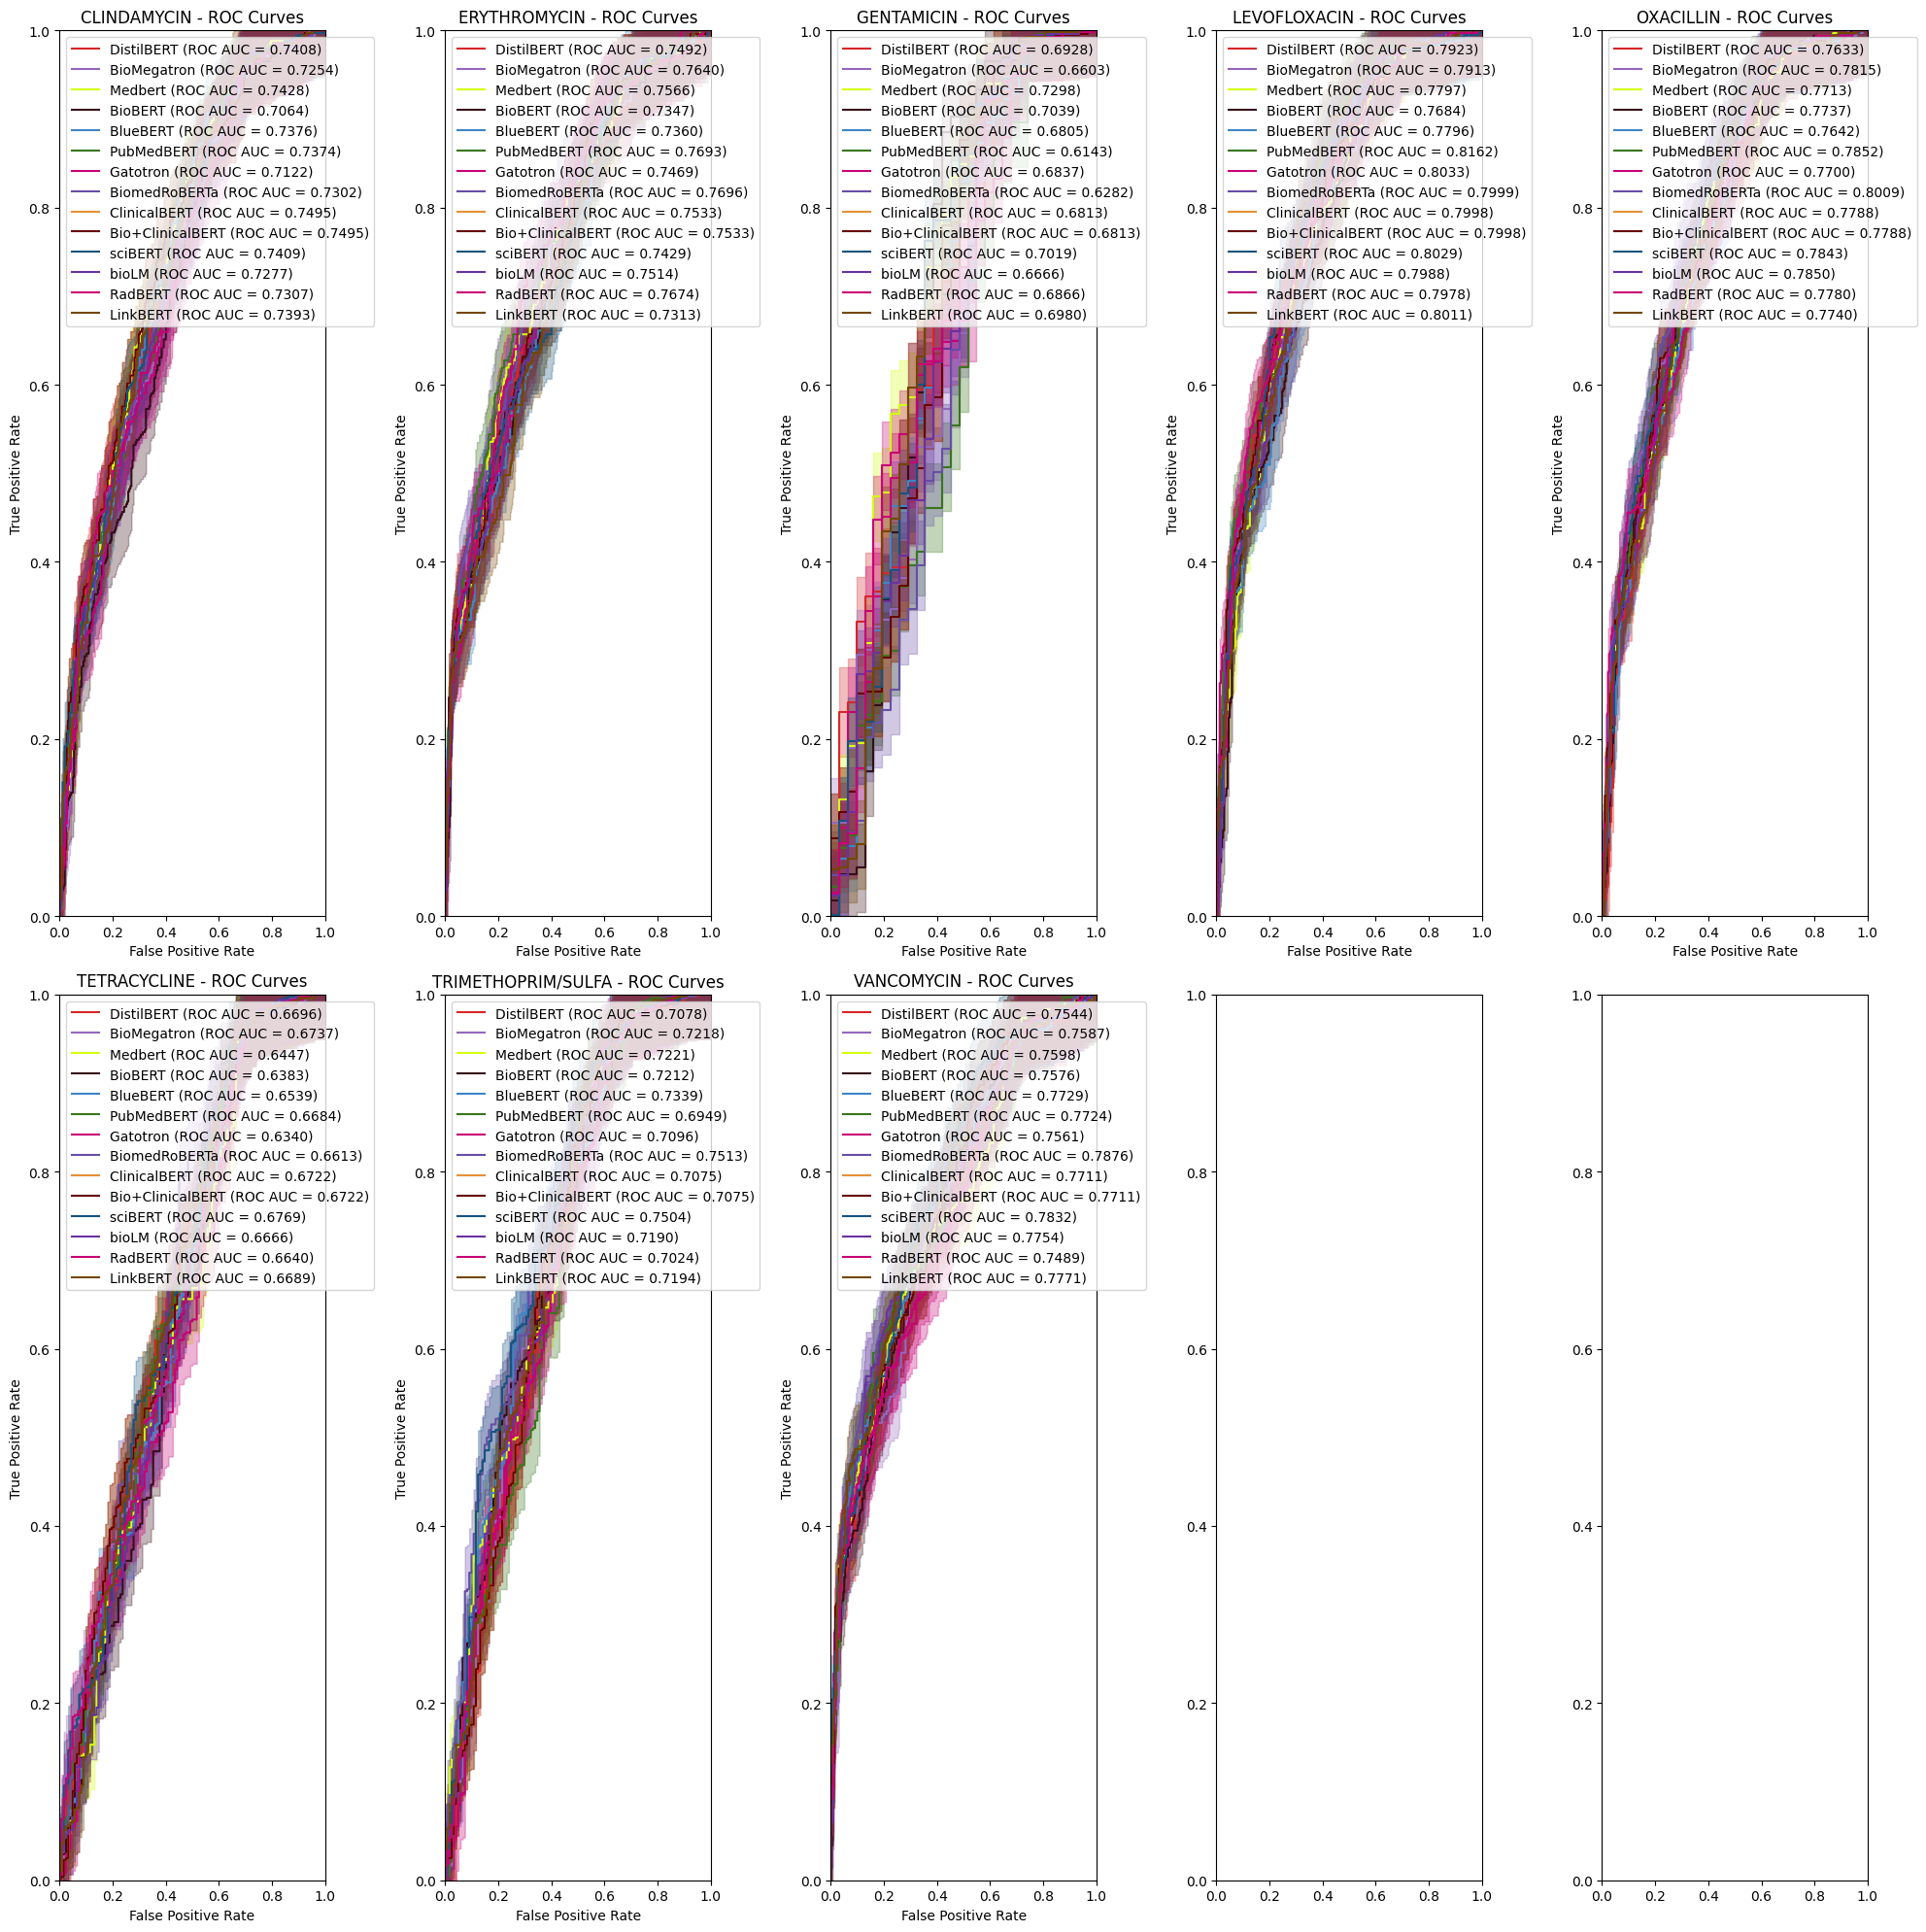

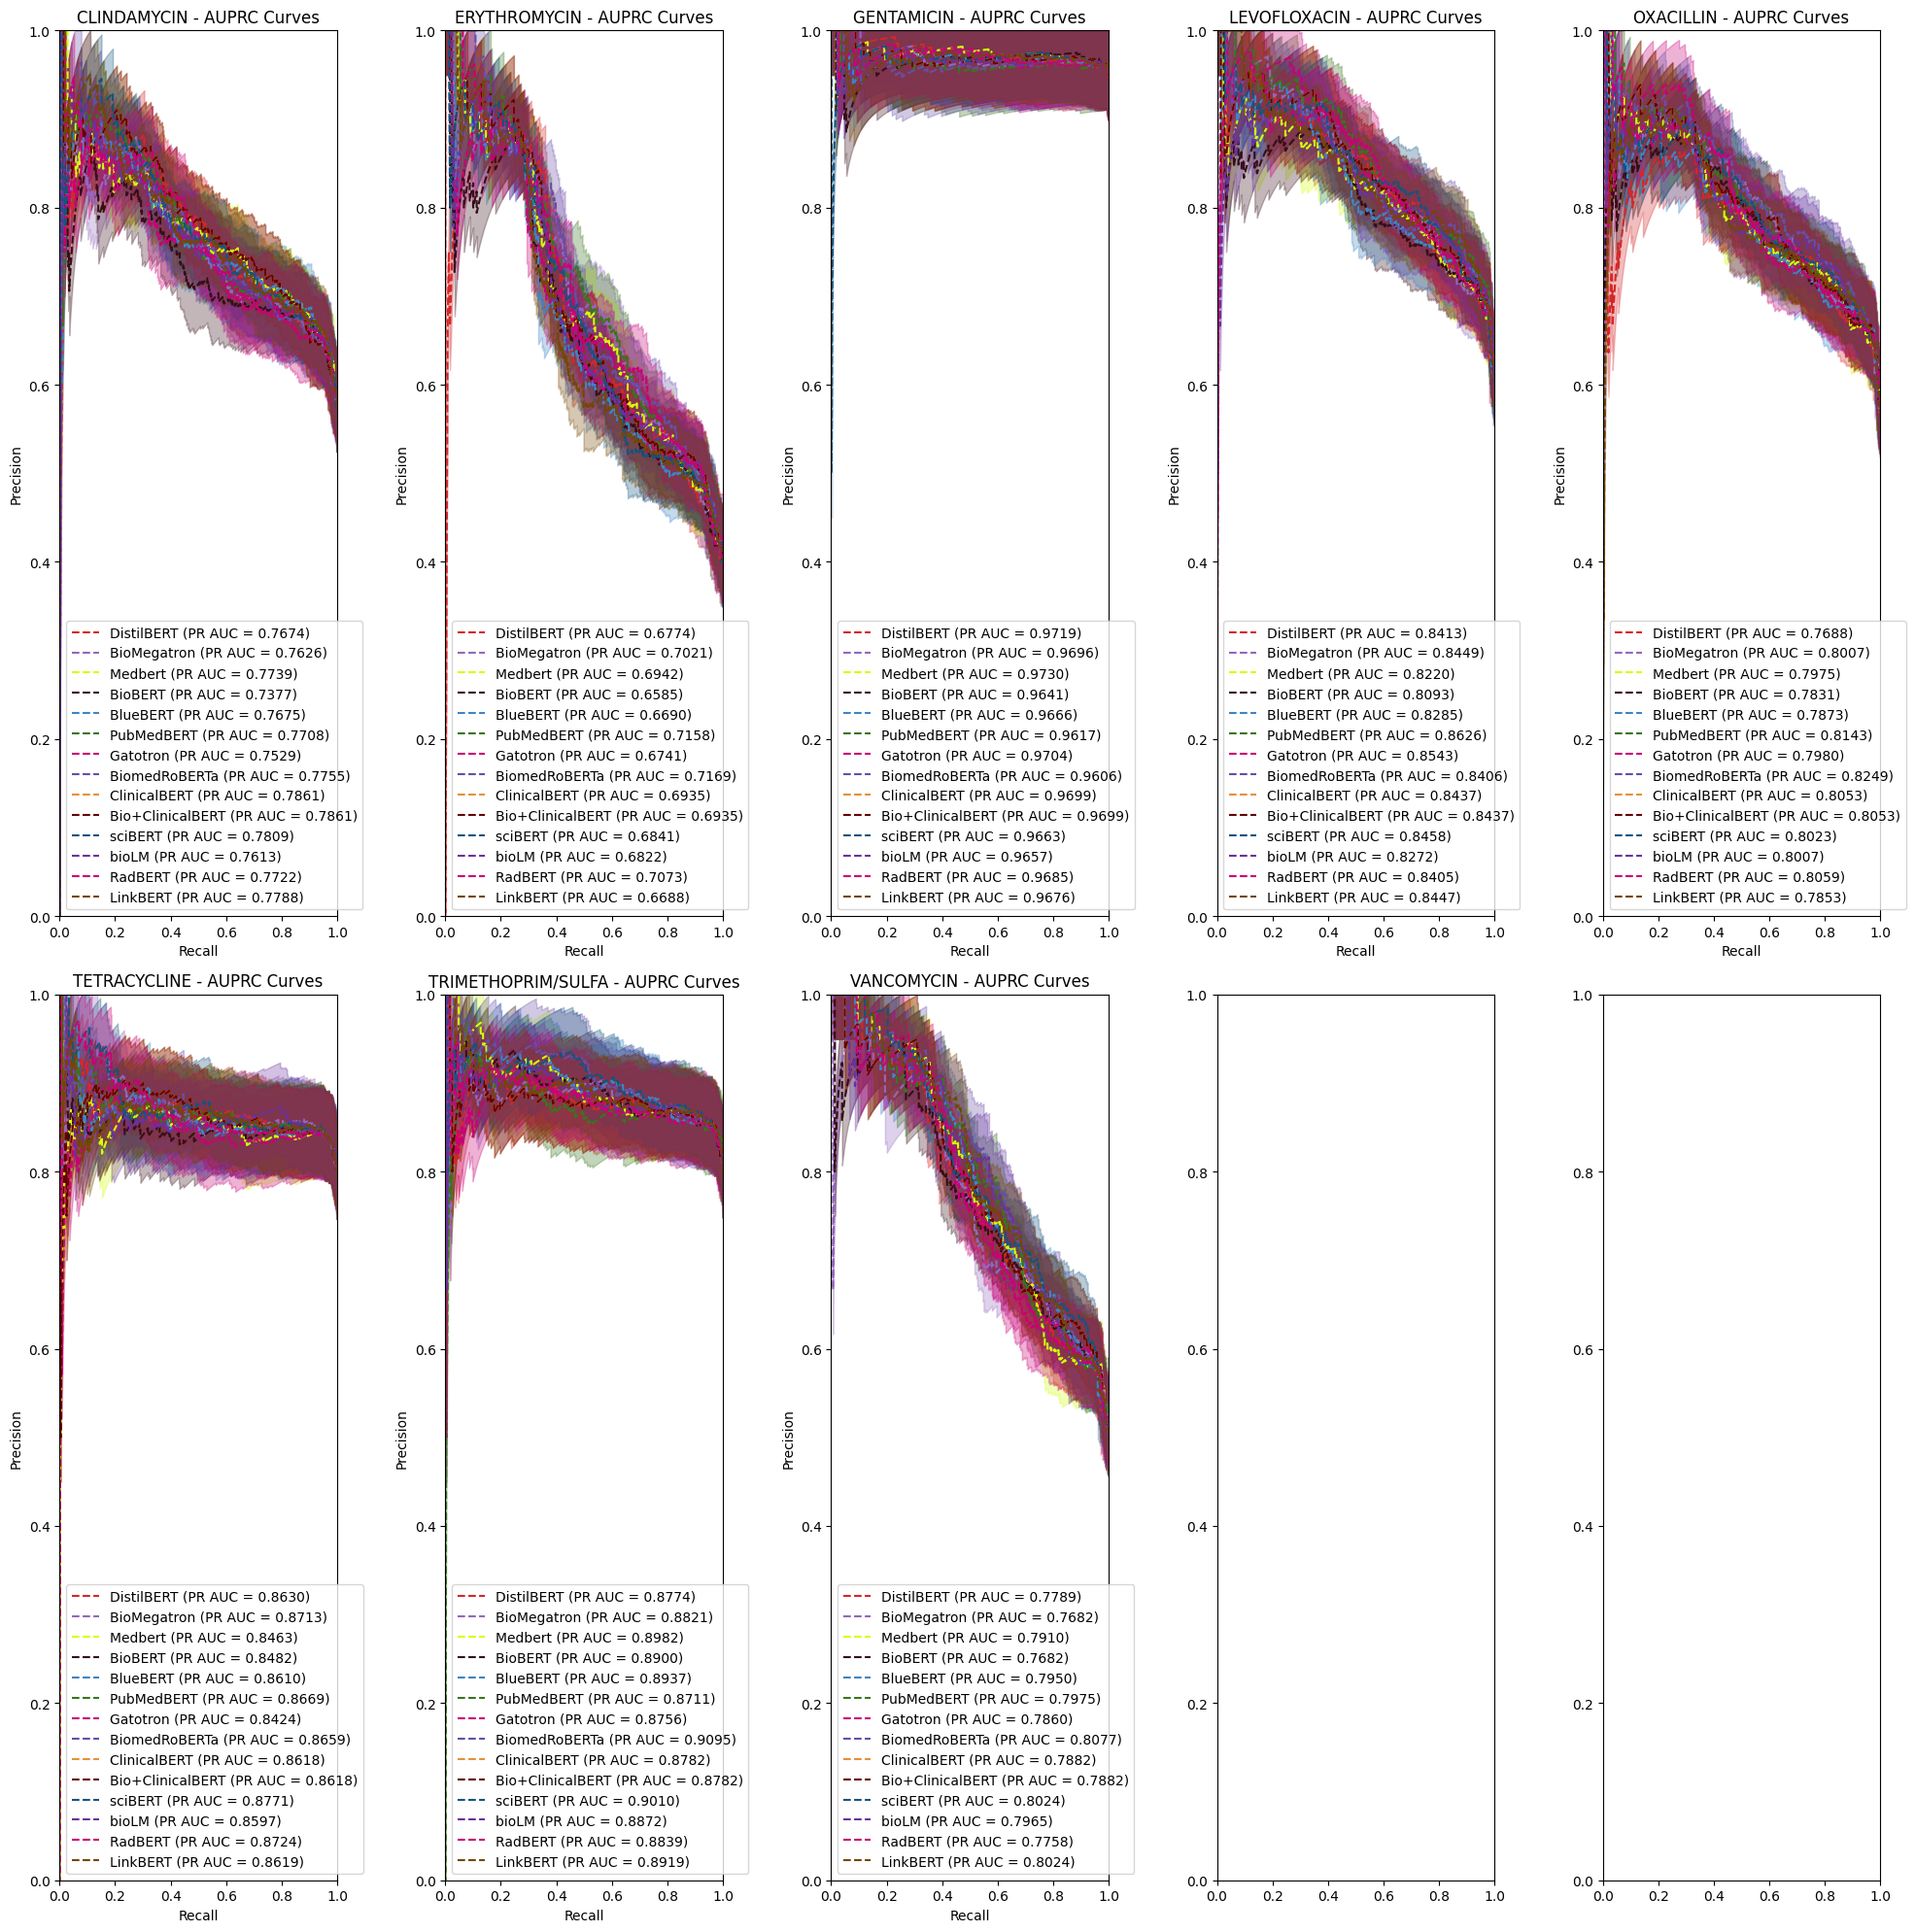

In [39]:
model_colors = {
    "DistilBERT": '#d62728',
    "BioMegatron": '#9467bd',
    "Medbert": "#d3ff0d",
    "BioBERT": "#370e19",
    "BlueBERT": "#3d85c6",
    "PubMedBERT": "#38761d",
    "Gatotron": "#c90076",
    "BiomedRoBERTa": "#674ea7",
    "ClinicalBERT": "#e69138",
    "Bio+ClinicalBERT": "#660000",
    "sciBERT": "#16537e",
    "bioLM": "#6a329f",
    "RadBERT": "#c90076",
    "LinkBERT": "#744700"
}

# Dictionaries with their corresponding model names
dictionaries = [
    (distilbert_results, "DistilBERT"),
    (biomegatron_results, "BioMegatron"),
    (medbert_results, "Medbert"),
    (biobert_results, "BioBERT"),
    (bluebert_results, "BlueBERT"),
    (pubmedbert_results, "PubMedBERT"),
    (gatotron_results, "Gatotron"),
    (biomedroberta_results, "BiomedRoBERTa"),
    (clinicalbert_results, "ClinicalBERT"),
    (bio_clinicalbert_results, "Bio+ClinicalBERT"),
    (scibert_results, "sciBERT"),
    (biolm_results, "bioLM"),
    (radbert_results, "RadBERT"),
    (linkbert_results, "LinkBERT")
]
plot_roc_curves(antibiotics, dictionaries, model_colors)
plot_auprc_curves(antibiotics, dictionaries, model_colors)

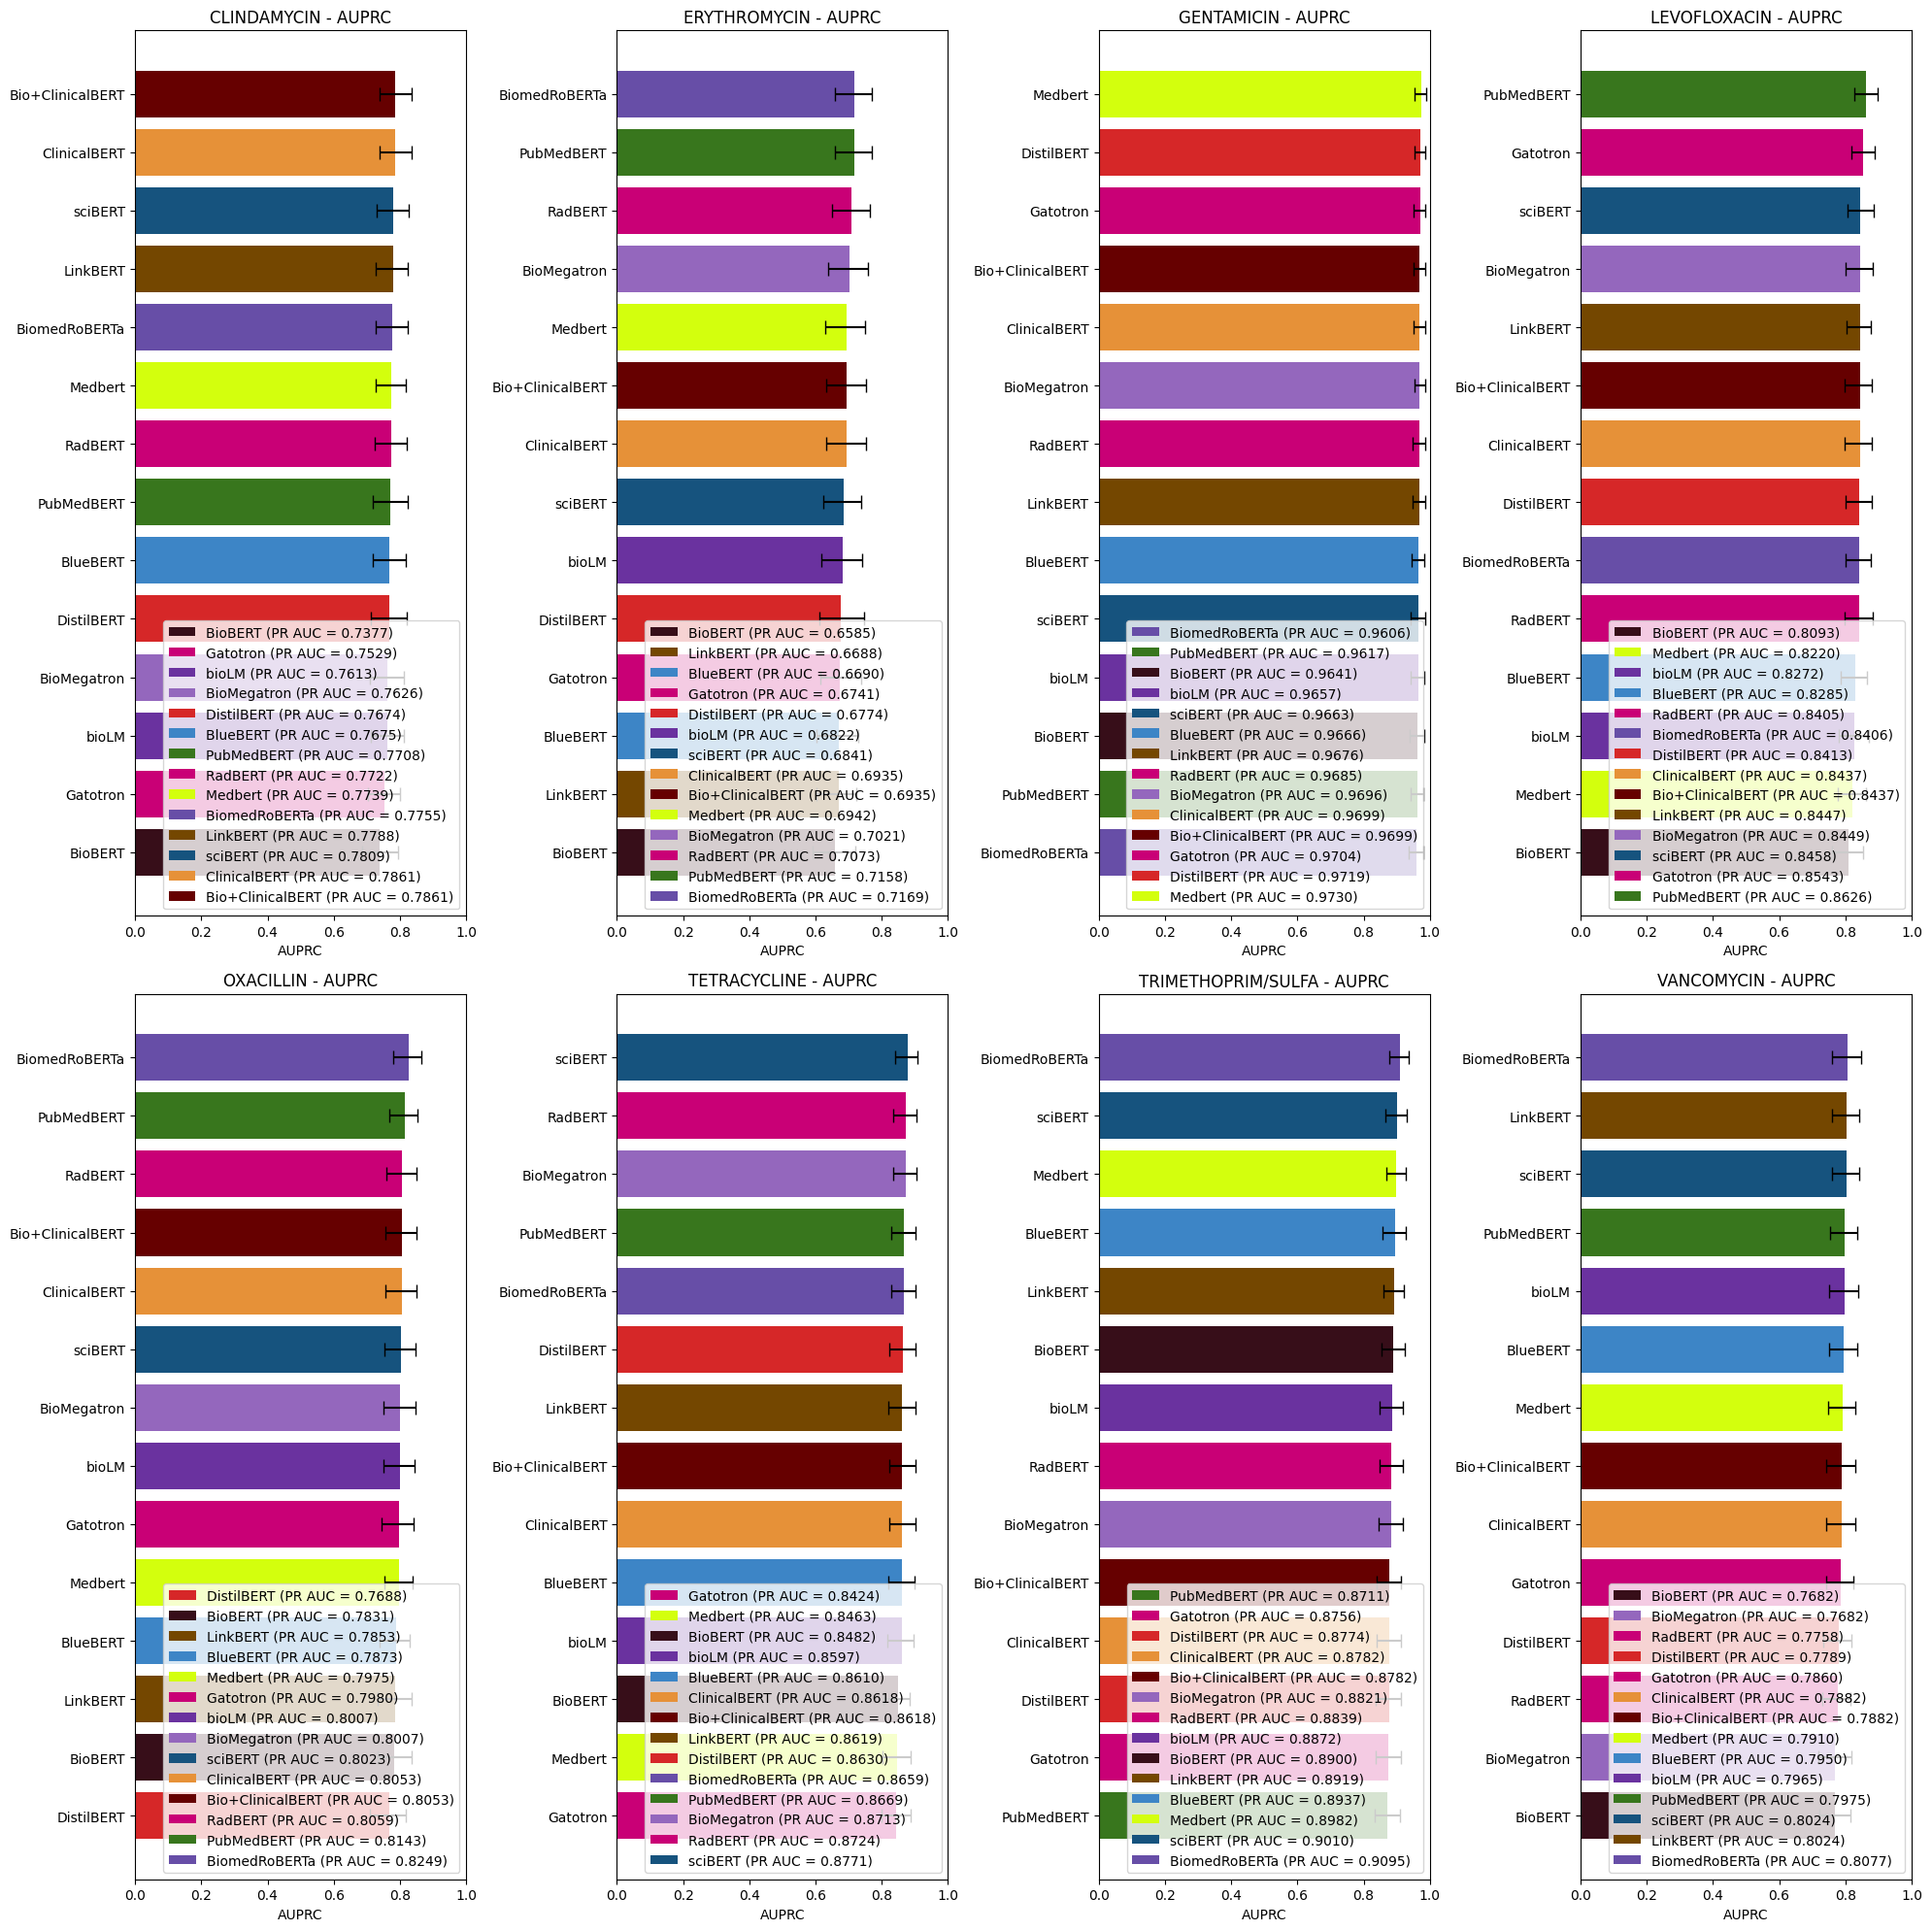

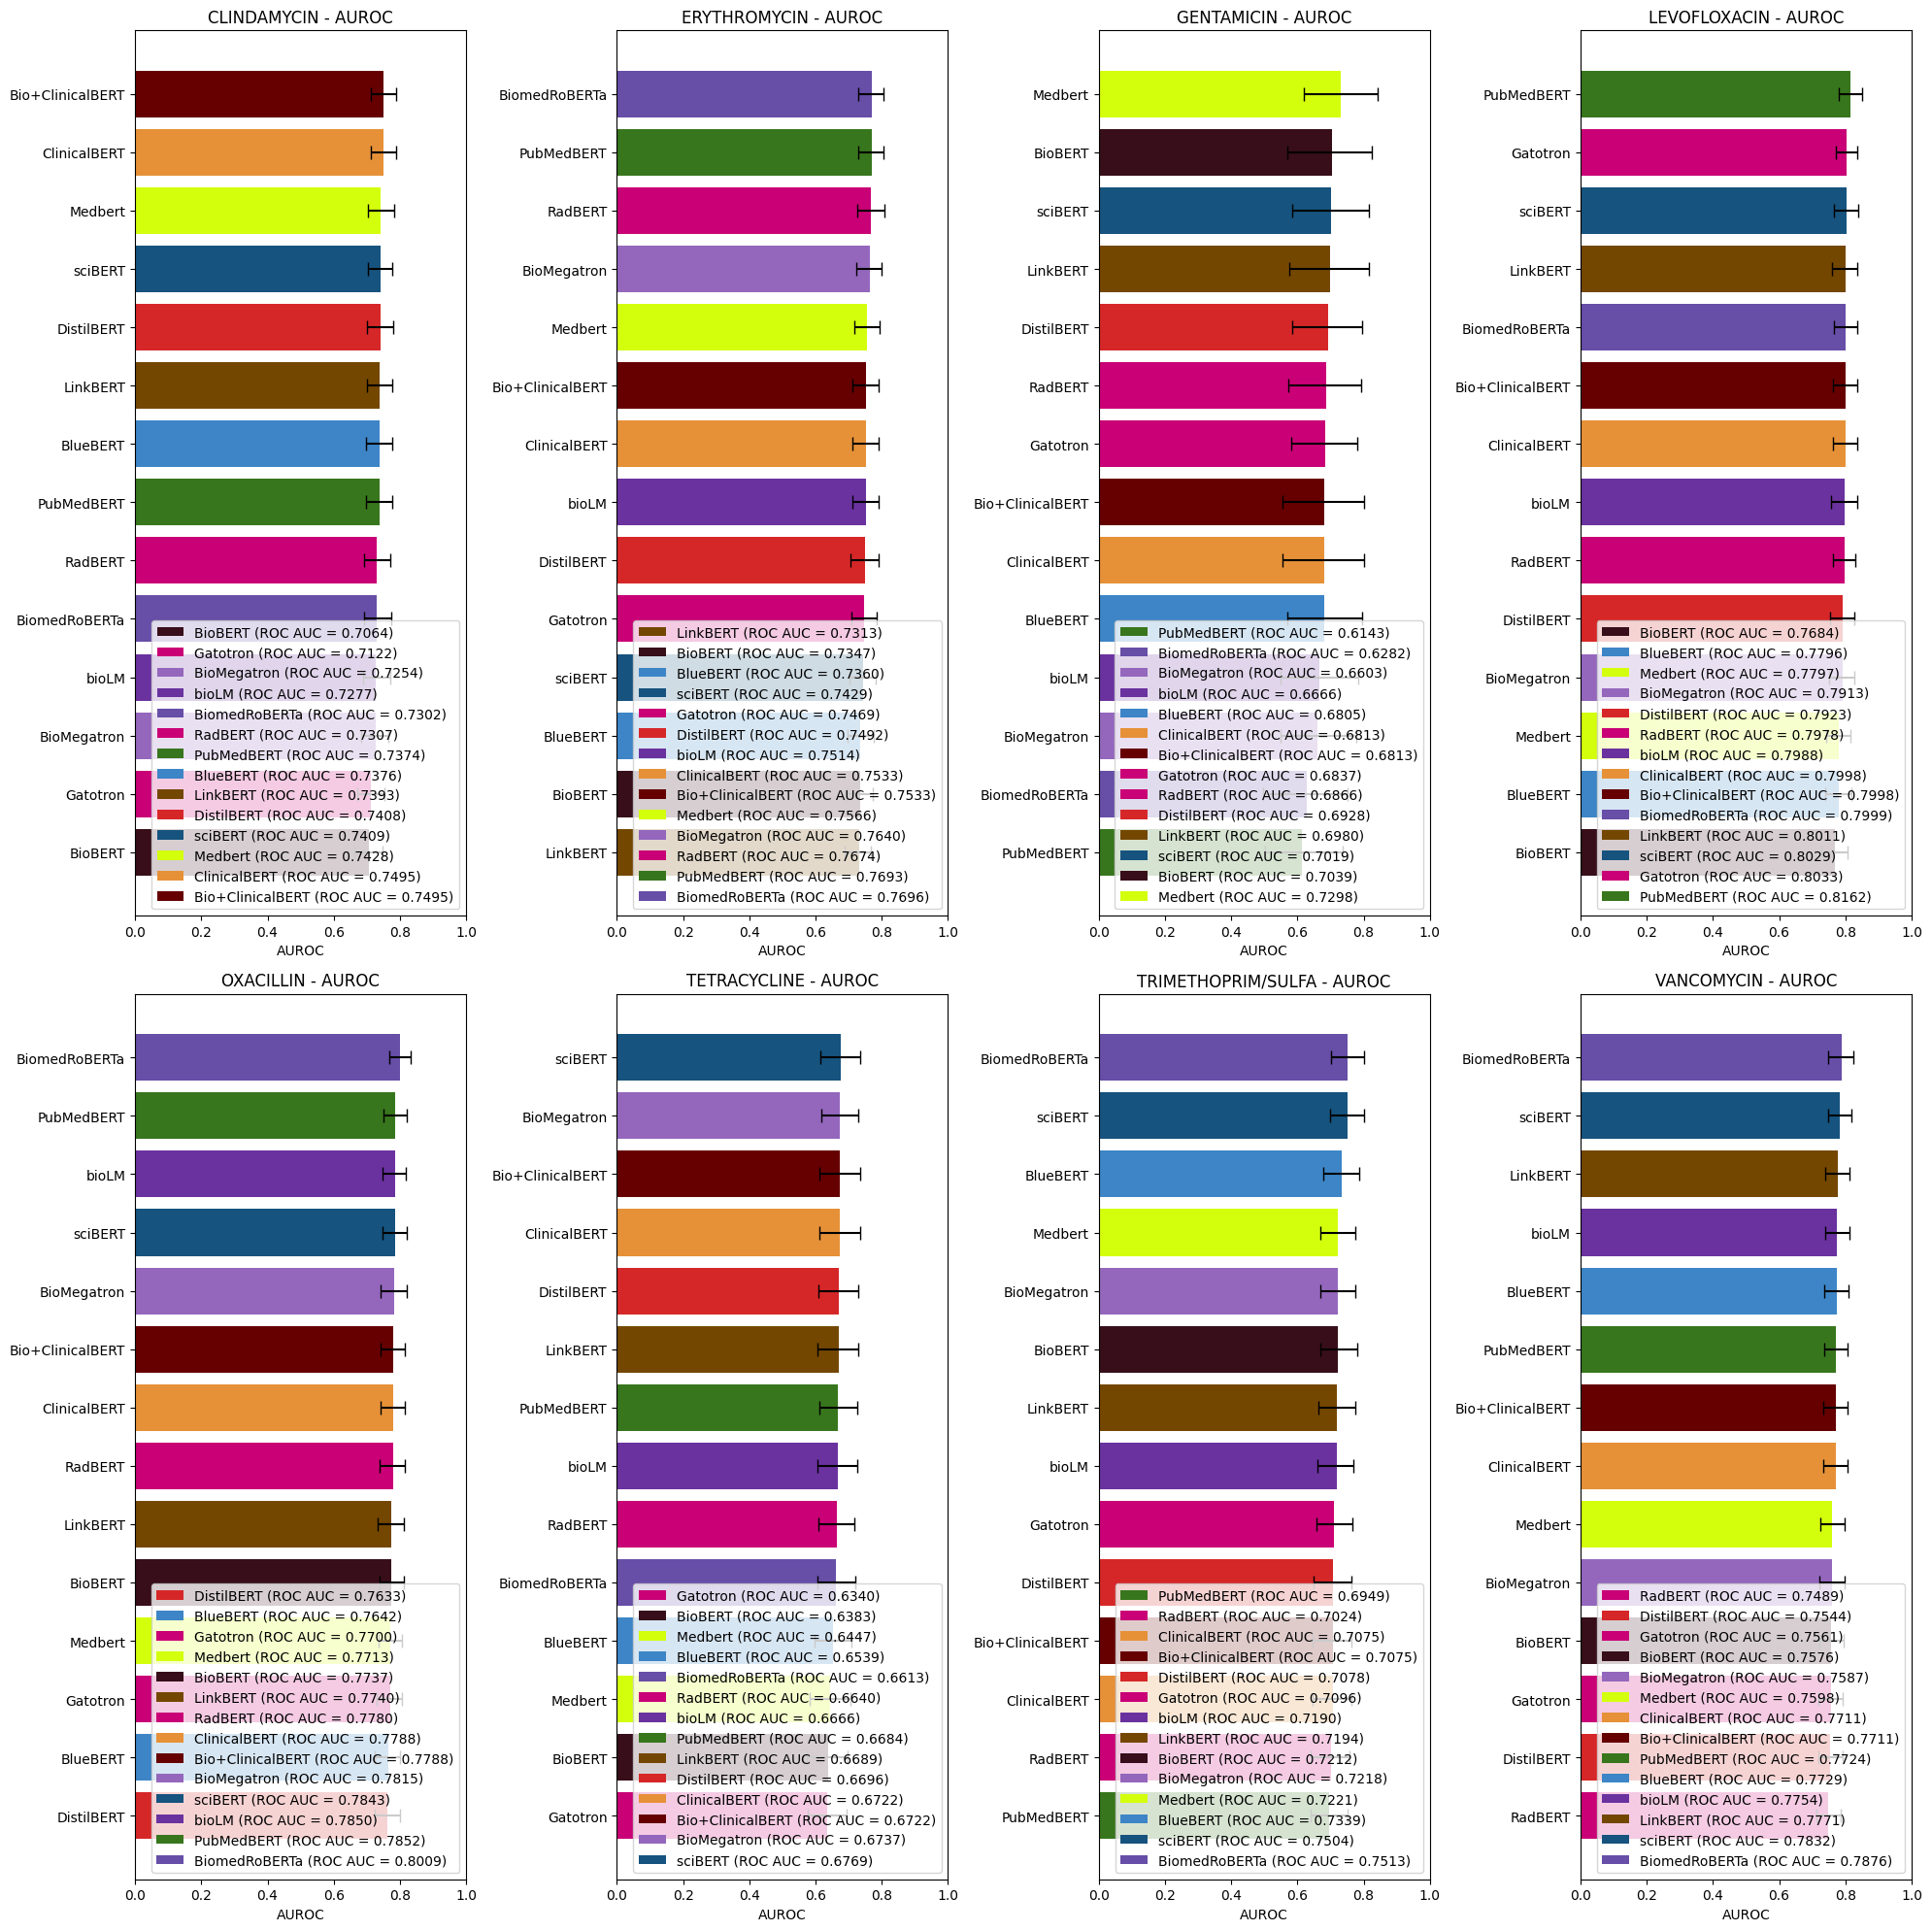

In [45]:
plot_bar_auprc(antibiotics, dictionaries, model_colors)
plot_bar_auroc(antibiotics, dictionaries, model_colors)

In [43]:
rank_roc = compute_average_rank(antibiotics, dictionaries, "ROC AUC")
rank_prc = compute_average_rank(antibiotics, dictionaries, "PRC AUC")

print(rank_roc, "\n",rank_prc)

{'sciBERT': 3.75, 'BiomedRoBERTa': 5.25, 'ClinicalBERT': 6.0, 'LinkBERT': 6.625, 'PubMedBERT': 6.75, 'Bio+ClinicalBERT': 7.0, 'Medbert': 7.125, 'BioMegatron': 7.625, 'bioLM': 7.625, 'DistilBERT': 8.875, 'RadBERT': 8.875, 'BlueBERT': 9.25, 'Gatotron': 9.875, 'BioBERT': 10.375} 
 {'sciBERT': 4.375, 'BiomedRoBERTa': 4.75, 'ClinicalBERT': 5.75, 'PubMedBERT': 5.875, 'RadBERT': 6.375, 'Bio+ClinicalBERT': 6.75, 'BioMegatron': 7.25, 'Medbert': 7.25, 'LinkBERT': 7.25, 'DistilBERT': 9.125, 'BlueBERT': 9.25, 'bioLM': 9.25, 'Gatotron': 9.375, 'BioBERT': 12.375}
